In [1]:
import math
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt

Parameters of grid:

In [2]:
JOBS = 1                          # Numbers of jobs
CRITERION = 1e-3                  # Convergence criterion
MAXITERATIONS = 100               # Maximal number of iterations
PERIODS = 20                      # Number of periods for simulation
AGENTS = 5000                     # Number of agents

AUGMA = 22000                     # Borrowing limit
NBA = 75                          # Number of assets points in the grid
AMIN = 1000                       # Minimal value of assets
AMAX = AMIN + 1.5*PERIODS*AUGMA   # Maximal value of assets
DELTAA = (AMAX - AMIN) / NBA      # Increment of assets

AUGMH = 4320                      # Maximum hours worked per year
NBH = 75                          # Number of hours worked points in the grid
HMIN = 1000                       # Minimal value of hours worked
HMAX = HMIN + 1.5*PERIODS*AUGMH   # Maximal value of hours worked
DELTAH = (HMAX - HMIN) / NBH      # Increment of hours worked

Earnings function parameters (Group 1):

In [3]:
WAGECONSTANT = 2.52                # Utility of being employed
ALPHA = 0.28                       # Performance pay premium
# Earnings premium
ZETA = [0, -.12, -.36, -.21, -.28, -.36, -.16, -.46, -.62] 
# Learning by doing
GAMMA = [0.76, 0.25, -0.02] 
XI = -0.07                         # Depreciation of human capital

Moments of model (All):

In [4]:
PSI = 0.41                         # Labor supply elasticity
CHI = 0.36                         # Disutility of labor supply

Parameters of model:

In [5]:
BETA = 0.98                           # Discount rate
R = 0.04                              # Fixed interest rate
IOTA = 0.5                            # Intertemporal elasticity of substitution
TAU = 0.29                            # Marginal tax rate

ZSHOCKS = 3                           # Number of discrete earnings shocks
z_shock_range = np.array([-0.2, 0, 0.2])  # Discrete earnings shocks range
pp_range = [0, 1]                     # List of possible PP states

# Probability of having PP given the job choice
PPDDISTRIBUTION = [0.039017, 0.065532, 0.065887, 0.096139, 0.088425, 0.298176, 
            0.106907, 0.134264, 0.105652]
            
# Transition matrix of discrete earnings shocks
PIMATRIX = np.array([0.1, 0.9, 0, 0.3, 0.4, 0.3, 0, 0.9, 0.1])
PIMATRIX = PIMATRIX.reshape(ZSHOCKS, ZSHOCKS)

# Probability of having discrete earnings shock
ZDISTRIBUTION = [0.2, 0.6, 0.2]

o_range = [False, True]               # List of possible o states

Global functions:

In [6]:
def map_to_index(pp, j, o):
    '''
    Return state index
    
    :param int pp: 1 = receiving PP, 0 = not receiving PP
    :param int j: current job type
    :param bool o: True = changed job, False = kept job
    '''
    if o:
        _o = 1
    else:
        _o = 0            
    return pp*( len(o_range)*JOBS ) + j*len(o_range) + _o

def wage(j, pp, h, h_cum, o, z_shock):
    '''
    Earnings function
    
    :param int j: current job type
    :param int pp: 1 = receiving PP, 0 = not receiving PP
    :param float h: current hours worked
    :param float h_cum: cumulative hours worked
    :param bool o: True = changed job, False = kept job
    :param float z_shock: shock
    '''
    if o:
        _o = 1
    else:
        _o = 0
    if h == 0:
        _log_h = -np.inf
    else:
        _log_h = math.log(h)
    return math.exp(
                WAGECONSTANT + 
                ALPHA*pp + 
                ZETA[j] + 
                GAMMA[0]*_log_h +
                GAMMA[1]*math.log(h_cum) + 
                GAMMA[2]*math.log(h_cum)*pp + 
                XI*_o +
                z_shock
                )

def consumption(a_prime, a, w):
    '''
    Consumption
    
    :param float a_prime: next period assets
    :param float a: current peruod assets
    :param float w: wage
    '''
    return (1 + R)*a - a_prime + (1 - TAU)*w
                
def labor(h_prime, h):
    '''
    Labor supply in hours
    
    :param float h_prime: next period cumulative hours worked
    :param float h: current peruod cumulative hours worked
    '''
    return (h_prime - h)
    
def utility(c, l):
    '''
    Utility function

    :param float c: consumption
    :param float l: labor supply
    '''
    return CHI*(c**(1-IOTA))/(1-IOTA) - (1 - CHI)*(l**(1+PSI))/(1+PSI) 

def augm(a):
    x = []
    for i in range(1, len(a)):
        x.append(a[i] - a[i-1])
    return np.array(x)

Model class:

In [7]:
class Model:
    '''
    Model
    '''

    def __init__(self, a_min=AMIN, a_max=AMAX, nb_a=NBA, augm_a=AUGMA,
                    h_min=HMIN, h_max=HMAX, nb_h=NBH, augm_h=AUGMH):
        '''
        :param float a_min: Minimal value of assets
        :param float a_max: Maximal value of assets
        :param int nb_a: Number of assets points in the grid
        :param float augm_a: Borrowing limit 
        :param float h_min: Minimal value of hours worked
        :param float h_max: Maximal value of hours worked
        :param int nb_h: Number of hours worked points in the grid
        :param float augm_h: Maximum hours worked per year

        '''
        (self.AMIN, self.AMAX, self.NBA) = (a_min, a_max, nb_a)
        (self.HMIN, self.HMAX, self.NBH) = (h_min, h_max, nb_h)
        self.AUGMA = augm_a
        self.AUGMH = augm_h
                
        self.DELTAA = (AMAX - AMIN) / NBA      # Increment of assets
        self.DELTAH = (HMAX - HMIN) / NBH      # Increment of hours worked
        
        self.a_grid = np.linspace(self.AMIN, self.AMAX, self.NBA)
        self.h_grid = np.linspace(self.HMIN, self.HMAX, self.NBH)
        
        self.util = []
        dr = np.zeros( (self.NBA*self.NBH, ZSHOCKS), dtype=int )
        v = np.zeros( (self.NBA*self.NBH, ZSHOCKS), dtype=float )
        self.v = [v] * ( len(pp_range)*len(o_range)*JOBS )
        self.dr = [dr] * ( len(pp_range)*len(o_range)*JOBS )
        

    def wage(self, j, pp, h_prime, h, o, z_shock):
        '''
        Earnings function on grid
        
        :param int j: current job type
        :param int pp: 1 = receiving PP, 0 = not receiving PP
        :param int h_prime: index of the next period cumulative hours worked
        :param int h: index of the current peruod cumulative hours worked
        :param bool o: True = changed job, False = kept job
        :param int z_shock: z-shock index
        '''
        if 2*h - h_prime < 0:
            _h_old = self.HMIN
        else:
            _h_old = self.HMIN + self.DELTAH*(2*h - h_prime)
        return wage( j, pp, (h_prime - h), _h_old, o, z_shock_range[z_shock] )
    
    def consumption(self, j, pp, h_prime, h, a_prime, a, o, z_shock):
        '''
        Consumption on grid
    
        :param int j: current job type
        :param int pp: 1 = receiving PP, 0 = not receiving PP
        :param int h_prime: index of the next period cumulative hours worked
        :param int h: index of the current peruod cumulative hours worked
        :param float a_prime: index of the next period assets
        :param float a: index of the current peruod assets
        :param bool o: True = changed job, False = kept job
        :param int z_shock: z-shock index
        '''
        _w = self.wage(j, pp, h_prime, h, o, z_shock)
        return consumption( self.AMIN + self.DELTAA*a_prime, self.AMIN + self.DELTAA*a, _w )
                
    def labor(self, h_prime, h):
        '''
        Labor supply on grid
    
        :param int h_prime: index of the next period cumulative hours worked
        :param int h: index of the current peruod cumulative hours worked
        '''
        return self.DELTAH * labor(h_prime, h)  / self.AUGMH
        
    def utility(self, c, l):
        '''
        Utility function on grid

        :param float c: consumption on grid
        :param float l: labor supply on grid
        '''
        return CHI*(c**(1-IOTA))/(1-IOTA) - \
               (1 - CHI)*(l**(1+PSI))/(1+PSI)       #utility(c, l)
        
    def evaluate_model(self):
        if len(self.util) == 0:
            self.update_utility_matrix()
        self.iterate_model()
        
    def update_utility_matrix(self):
        print("Updating utility matrix", end='')
        for pp in pp_range:
            for j in range(JOBS):
                for o in o_range:
                    print(".", end='')
                    _temp_um = np.zeros((self.NBA*self.NBH, self.NBA*self.NBH, ZSHOCKS), dtype=float)
                    _temp_um.fill(np.nan) 
                
                    for z_shock in range(ZSHOCKS): 
                        for h_start in range(self.NBH):
                            for a_start in range(self.NBA):
                                for h_end in range(h_start, self.NBH):
                                    if h_end - h_start > self.AUGMH/self.DELTAH:
                                        continue
                                    for a_end in range(a_start, self.NBA):
                                        if a_end - a_start > self.AUGMA/self.DELTAA:
                                            continue
                                        _c = self.consumption(j, pp, 
                                                            h_end, h_start, 
                                                            a_end, a_start,
                                                            o, z_shock);
                                        if _c < 0:
                                            continue
                                        _l = self.labor(h_end, h_start)
                                        _temp_um[a_start + h_start*self.NBA, 
                                                    a_end + h_end*self.NBA, 
                                                    z_shock] = \
                                            self.utility(_c, _l)
                    self.util.append(_temp_um)
        print(" Done")

    def iterate_model(self):
        _temp_u0 = np.zeros( (self.NBA*self.NBH*ZSHOCKS), dtype=float )
        _distance = 1
        _iteration = 0
        
        while _distance > CRITERION and _iteration < MAXITERATIONS:
            _dr = []
            _temp_v = []

            for pp in pp_range:
                for j in range(JOBS):
                    for o in o_range:
                        _dr.append( np.nanargmax(
                                    self.util[map_to_index(pp, j, o)] + 
                                    BETA*np.tile( self.v[map_to_index(pp, j, o)]
                                    .dot(PIMATRIX), 
                                    (self.NBA*self.NBH, 1, 1)), axis=1 ) )
                        _Q = sp.lil_matrix( 
                                    (self.NBA*self.NBH*ZSHOCKS, self.NBA*self.NBH*ZSHOCKS), 
                                    dtype=float )

                        for z_shock in range(ZSHOCKS):
                            _Q0 = sp.lil_matrix( (self.NBA*self.NBH, self.NBA*self.NBH), 
                                                    dtype=float )
                            for i in range(self.NBA*self.NBH):
                                _Q0[i, _dr[map_to_index(pp, j, o)][i, 
                                                                z_shock]] = 1
                                _temp_u0[i + z_shock*self.NBA*self.NBH] = \
                                    self.util[map_to_index(pp, j, o)][i, 
                                        _dr[map_to_index(pp, j, o)][i, z_shock], 
                                        z_shock]
                            _Q[z_shock*self.NBA*self.NBH : (z_shock + 1)*self.NBA*self.NBH, :] = \
                                    sp.kron( PIMATRIX[:, z_shock], _Q0 )            

                        _temp_u0 += np.euler_gamma
                        _solution = spsolve( 
                                    (sp.eye(self.NBA*self.NBH*ZSHOCKS) - BETA*_Q), 
                                    _temp_u0 )
                        _temp_v.append( 
                                    _solution.reshape( (ZSHOCKS, self.NBA*self.NBH)).T )

            _distance = np.max( abs( np.array(self.dr) - np.array(_dr) ) )

            _iteration +=1
            self.v = _temp_v
            self.dr = _dr

            print("Iteration: {0:2d}; Distance: {1:d}".format(_iteration, _distance))
            if _iteration == MAXITERATIONS:
                print("Max number of iterations reached!")
    
    def save_to_csv(self):
        _size = len(pp_range)*len(o_range)*JOBS*self.NBA*self.NBH
        _df = pd.DataFrame(np.array(self.dr).reshape(_size, ZSHOCKS),
                                columns=z_shock_range)
        _df.to_csv('dr.csv')
        _df = pd.DataFrame(np.array(self.v).reshape(_size, ZSHOCKS),
                                columns=z_shock_range)
        _df.to_csv('v.csv')
        
    def load_from_csv(self):
        _df = pd.read_csv('dr.csv', index_col=0)
        self.dr = _df.as_matrix().reshape(len(pp_range)*len(o_range)*JOBS, 
                            self.NBA*self.NBH, ZSHOCKS)
        _df = pd.read_csv('v.csv', index_col=0)
        self.v = _df.as_matrix().reshape(len(pp_range)*len(o_range)*JOBS, 
                            self.NBA*self.NBH, ZSHOCKS)
    
    def show(self, i, j, k):
        plt.figure()
        plt.plot( self.h_grid, self.h_grid )
        plt.plot( self.h_grid,
                 self.h_grid[self.dr[i].
                 reshape(self.NBH, self.NBA, ZSHOCKS)[:, j, k] // self.NBA] )

        plt.figure()
        plt.plot( self.a_grid, self.a_grid )
        plt.plot( self.a_grid,
                 self.a_grid[self.dr[i].
                 reshape(self.NBH, self.NBA, ZSHOCKS)[j, :, k] % self.NBA] )

        plt.show()

Model evaluation:

In [8]:
m = Model()

m.evaluate_model()

Updating utility matrix.... Done
Iteration:  1; Distance: 5624
Iteration:  2; Distance: 152
Iteration:  3; Distance: 151
Iteration:  4; Distance: 151
Iteration:  5; Distance: 151
Iteration:  6; Distance: 150
Iteration:  7; Distance: 76
Iteration:  8; Distance: 76
Iteration:  9; Distance: 150
Iteration: 10; Distance: 76
Iteration: 11; Distance: 75
Iteration: 12; Distance: 75
Iteration: 13; Distance: 75
Iteration: 14; Distance: 0


Simulation utilities:

In [9]:
def simulate_agent(m, log=True):
    _dr_idx = NBA // 2
    _h = m.HMIN + (_dr_idx // m.NBA)*m.DELTAH
    _a = m.AMIN + (_dr_idx % m.NBA)*m.DELTAA
    res = np.array( [(0.0, 0.0, 0.0, 0.0, 0.0)]*PERIODS )
    if log:
        print(" Period| Job| PP| Shock|     h|      a|    l|       c|       w ")
        print(" {0:6d}|   -|  -|     -|{1:6.0f}|{2: 6.0f}|    -|       -|       -".
                format(0, _h, _a) )
    _chosen = -1
    for period in range(PERIODS):            
        _temp_v = [0]*JOBS
        _temp_idx = [0]*JOBS
        _temp_state = [(0,0,0)]*JOBS
        for j in range(JOBS):
            _pp_prob = rnd.random()
            if (_pp_prob < PPDDISTRIBUTION[j]):
                pp = 1
            else:
                pp = 0
            _z_shock_prob = rnd.random()
            _z_index = 0
            _sum = ZDISTRIBUTION[_z_index]
            while (_sum < _z_shock_prob):
                _z_index += 1
                _sum += ZDISTRIBUTION[_z_index]
            _temp_idx[j] = m.dr[map_to_index(pp, j, 
                j != _chosen)].reshape(m.NBA*m.NBH, ZSHOCKS)[_dr_idx, _z_index]
            _temp_v[j] = m.v[map_to_index(pp, j, 
                j != _chosen)].reshape(m.NBA*m.NBH, ZSHOCKS)[_temp_idx[j], _z_index]
            _temp_state[j] = (pp, j == _chosen, z_shock_range[_z_index])
        _chosen = np.argmax(_temp_v)
                
        _l = labor(m.HMIN + (_temp_idx[_chosen] // m.NBA)*m.DELTAH, 
                    m.HMIN + (_dr_idx // m.NBA)*m.DELTAH) / m.AUGMH
        _w = wage( _chosen, 
                    _temp_state[_chosen][0], 
                    _l*m.AUGMH,
                    m.HMIN + (_dr_idx // m.NBA)*m.DELTAH, 
                    _temp_state[_chosen][1],
                    _temp_state[_chosen][2] )
        _c = consumption(m.AMIN + (_temp_idx[_chosen] % m.NBA)*m.DELTAA,
                m.AMIN + (_dr_idx % m.NBA)*m.DELTAA, _w)
        _dr_idx = _temp_idx[_chosen]
        _h = m.HMIN + (_dr_idx // m.NBA)*m.DELTAH
        _a = m.AMIN + (_dr_idx % m.NBA)*m.DELTAA
        
        res[period] = (_h, _a, _l, _c, _w)
        if log:
            print(" {0:6d}|{1: 4d}|{2: 3d}|{3: 6.1f}|".
                    format(period + 1,
                    _chosen, 
                    _temp_state[_chosen][0], 
                    _temp_state[_chosen][2]) +
                    "{0:6.0f}|{1: 6.0f}|{2: 5.2f}|{3: 8.0f}|{4: 8.0f}".
                        format(_h, _a, _l, _c, _w) )
    return res
        
def integrate(m):
    average = np.array( [(0.0, 0.0, 0.0, 0.0, 0.0)]*PERIODS )
    for agent in range(AGENTS):
        average += simulate_agent(m, log=False)
    average /= AGENTS
    print("     h|      a|    l|     c|     w ")
    for period in range(PERIODS):   
        (_h, _a, _l, _c, _w) = tuple(average[period])       
        print("{0:6.0f}|{1: 6.0f}|{2: 5.2f}|{3: 6.0f}|{4: 6.0f}".
                        format( _h, _a, _l, _c, _w ) )
    return average

Simulate all agents:

In [10]:
res = integrate(m)

     h|      a|    l|     c|     w 
  4112| 331864| 0.72| 30790| 32380
  6954| 337197| 0.66| 35676| 39062
 10066| 342568| 0.72| 42774| 48813
 13171| 347792| 0.72| 46466| 53502
 16291| 353148| 0.72| 49326| 57422
 19408| 358396| 0.72| 51921| 60625
 22515| 363688| 0.72| 53747| 62962
 25630| 368967| 0.72| 55867| 65630
 28747| 374303| 0.72| 57498| 67712
 31854| 379477| 0.72| 59326| 69758
 34961| 384817| 0.72| 60377| 71181
 38065| 390103| 0.72| 61831| 72851
 41189| 395344| 0.72| 63759| 75206
 44310| 400664| 0.72| 64747| 76414
 47423| 405960| 0.72| 65857| 77642
 50539| 411272| 0.72| 67059| 79059
 53661| 416652| 0.72| 68274| 80568
 56783| 422260| 0.72| 68999| 81606
 59887| 427994| 0.72| 69664| 82405
 62964| 434192| 0.71| 69692| 82777


Plot the results:

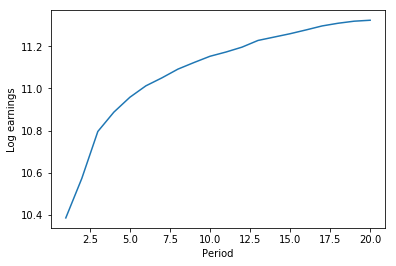

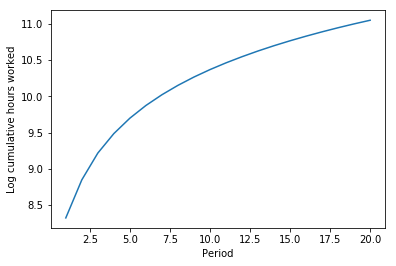

In [11]:
plt.figure()
plt.plot(np.linspace(1,PERIODS,PERIODS), np.log(res[:,4]))
plt.xlabel("Period")
plt.ylabel("Log earnings")
plt.figure()
plt.plot(np.linspace(1,PERIODS,PERIODS), np.log(res[:,0]))
plt.xlabel("Period")
plt.ylabel("Log cumulative hours worked")
plt.show()

Recalculate the moments:

In [12]:
#PSI
ar1 = res[1:,4]
ar2 = augm(res[:,0])

PSI = np.cov(ar1, ar2)[0,1] / (np.std(ar1) * np.std(ar2))
CHI = np.mean(res[:,2])

print("PSI: {0: 0.3f}\nCHI: {1: 0.3f}".format(PSI, CHI))

PSI:  0.588
CHI:  0.717


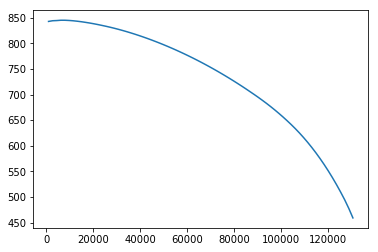

In [17]:
plt.plot(m.h_grid, m.v[2].reshape(m.NBH, m.NBA, ZSHOCKS)[:,0, 1] )
plt.show()